<a href="https://colab.research.google.com/github/thomasj-s/thomasj-s.github.io/blob/gh-pages/BUILD_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import pandas as pd
import numpy as np
import math
from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as pltt

In [4]:
 ### READ IN
 
 mlb1 = pd.read_csv('/content/mlb_elo.csv')
 mlb1.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,rating1_pre,rating2_pre,pitcher1,pitcher2,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2019-10-30,2019,0,w,HOU,WSN,1599.542804,1584.363378,0.574617,0.425383,1594.882297,1589.023885,1591.026009,1580.329587,Zack Greinke,Max Scherzer,56.920649,61.723620,0.989236,27.776342,0.515172,0.484828,1587.973463,1583.382133,2,6
1,2019-10-29,2019,0,w,HOU,WSN,1605.069000,1578.837182,0.595209,0.404791,1599.542804,1584.363378,1595.165625,1576.189971,Justin Verlander,Stephen Strasburg,62.975093,60.272516,28.723451,21.776276,0.594638,0.405362,1591.026009,1580.329587,2,7
2,2019-10-27,2019,0,w,WSN,HOU,1584.005206,1599.900976,0.515546,0.484454,1578.837182,1605.069000,1578.722119,1592.633477,Joe Ross,Gerrit Cole,49.433198,66.891460,-29.811205,47.888341,0.373102,0.626898,1576.189971,1595.165625,1,7
3,2019-10-26,2019,0,w,WSN,HOU,1589.985555,1593.920627,0.538425,0.461575,1584.005206,1599.900976,1583.715416,1587.640180,Patrick Corbin,Jose Urquidy,56.003581,51.251046,0.823752,-24.893480,0.586974,0.413026,1578.722119,1592.633477,1,8
4,2019-10-25,2019,0,w,WSN,HOU,1593.827376,1590.078806,0.553044,0.446956,1589.985555,1593.920627,1586.428733,1584.926863,Anibal Sanchez,Zack Greinke,54.036365,57.096801,-9.053908,2.440389,0.526852,0.473148,1583.715416,1587.640180,1,4


In [5]:
### PREVIEW SHAPE

mlb1.shape

(220010, 26)

In [6]:
### SEARCH FOR NULL DATA

mlb1.isnull().sum()

date                 0
season               0
neutral              0
playoff         218393
team1                0
team2                0
elo1_pre             0
elo2_pre             0
elo_prob1            0
elo_prob2            0
elo1_post            0
elo2_post            0
rating1_pre          0
rating2_pre          0
pitcher1            38
pitcher2            38
pitcher1_rgs     33741
pitcher2_rgs     33741
pitcher1_adj     34422
pitcher2_adj     34421
rating_prob1         0
rating_prob2         0
rating1_post         0
rating2_post         0
score1               0
score2               0
dtype: int64

In [7]:
mlb1['playoff'].value_counts()

# We assume that non-playoff games are marked as Nan values based on this output.
# This is okay, as we will check for null data along the way, and not be using
# the column for which most null data is present.

w    672
l    514
d    415
c     16
Name: playoff, dtype: int64

In [92]:
### CREATE DATASET FOR EACH YEAR 2012 - 2019 and concatenate into new dataset
### representing the last 8 years

mlb2019 = mlb1[mlb1['date'].str.contains('2019')]
mlb2018 = mlb1[mlb1['date'].str.contains('2018')]
mlb2017 = mlb1[mlb1['date'].str.contains('2017')]
mlb2016 = mlb1[mlb1['date'].str.contains('2016')]
mlb2015 = mlb1[mlb1['date'].str.contains('2015')]
mlb2014 = mlb1[mlb1['date'].str.contains('2014')]
mlb2013 = mlb1[mlb1['date'].str.contains('2013')]
mlb2012 = mlb1[mlb1['date'].str.contains('2012')]

mlb = pd.concat([mlb2019, mlb2018, mlb2017, mlb2016, mlb2015, mlb2014, mlb2013, mlb2012])
print(mlb.shape)
mlb


### Row count seems to confirmed that our data is the right size for being the 
### last 8 years of mlb play with 162 games per season per team.

(19724, 26)


,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,rating1_pre,rating2_pre,pitcher1,pitcher2,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2019-10-30,2019,0,w,HOU,WSN,1599.542804,1584.363378,0.574617,0.425383,1594.882297,1589.023885,1591.026009,1580.329587,Zack Greinke,Max Scherzer,56.920649,61.723620,0.989236,27.776342,0.515172,0.484828,1587.973463,1583.382133,2,6
1,2019-10-29,2019,0,w,HOU,WSN,1605.069000,1578.837182,0.595209,0.404791,1599.542804,1584.363378,1595.165625,1576.189971,Justin Verlander,Stephen Strasburg,62.975093,60.272516,28.723451,21.776276,0.594638,0.405362,1591.026009,1580.329587,2,7
2,2019-10-27,2019,0,w,WSN,HOU,1584.005206,1599.900976,0.515546,0.484454,1578.837182,1605.069000,1578.722119,1592.633477,Joe Ross,Gerrit Cole,49.433198,66.891460,-29.811205,47.888341,0.373102,0.626898,1576.189971,1595.165625,1,7
3,2019-10-26,2019,0,w,WSN,HOU,1589.985555,1593.920627,0.538425,0.461575,1584.005206,1599.900976,1583.715416,1587.640180,Patrick Corbin,Jose Urquidy,56.003581,51.251046,0.823752,-24.893480,0.586974,0.413026,1578.722119,1592.633477,1,8
4,2019-10-25,2019,0,w,WSN,HOU,1593.827376,1590.078806,0.553044,0.446956,1589.985555,1593.920627,1586.428733,1584.926863,Anibal Sanchez,Zack Greinke,54.036365,57.096801,-9.053908,2.440389,0.526852,0.473148,1583.715416,1587.640180,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19719,2012-04-05,2012,0,NaN,CIN,FLA,1498.862000,1482.164000,0.558303,0.441697,1501.113000,1479.913000,1499.768000,1482.030000,Johnny Cueto,Mark Buehrle,54.502000,50.178000,25.723100,3.097300,0.601788,0.398212,1501.768000,1480.030000,4,0
19720,2012-04-05,2012,0,NaN,CHC,WSN,1484.189000,1500.116000,0.511616,0.488384,1482.723000,1501.582000,1483.633000,1500.984000,Ryan Dempster,Stephen Strasburg,49.521000,53.996000,3.708300,19.993800,0.485507,0.514493,1482.245000,1502.372000,1,2
19721,2012-04-04,2012,0,NaN,FLA,STL,1484.204000,1538.483000,0.456535,0.543465,1482.164000,1540.522000,1484.567000,1538.449000,Josh Johnson,Kyle Lohse,59.491000,47.856000,46.661600,-10.086200,0.543103,0.456897,1482.030000,1540.986000,1,4
19722,2012-03-29,2012,1,NaN,OAK,SEA,1500.288000,1473.041000,0.539131,0.460869,1502.305000,1471.024000,1500.775000,1473.735000,Bartolo Colon,Jason Vargas,47.508000,47.648000,-15.909500,-8.920600,0.528824,0.471176,1502.850000,1471.659000,4,1


In [9]:
### Check for null data

mlb.isnull().sum()
# We drop a shitload of null data here after the concat

date                0
season              0
neutral             0
playoff         19438
team1               0
team2               0
elo1_pre            0
elo2_pre            0
elo_prob1           0
elo_prob2           0
elo1_post           0
elo2_post           0
rating1_pre         0
rating2_pre         0
pitcher1            0
pitcher2            0
pitcher1_rgs        0
pitcher2_rgs        0
pitcher1_adj        2
pitcher2_adj        1
rating_prob1        0
rating_prob2        0
rating1_post        0
rating2_post        0
score1              0
score2              0
dtype: int64

In [10]:
### Extrapolate a list of team records for the last 8 years.

teams = pd.DataFrame([mlb.team1.unique()[:30]])  
# We double checked the list output to be sure that the first 
# 30 items were the 30 active mlb teams.
teams = teams.T
teams = teams.rename(columns={0:'Team'})
print(teams.shape)
teams.head()

# This list is very important, as we later use it to assign columns to in
# the dataset.  We format all of our future data to be in the same order
# as this list so it merges accurately.

(30, 1)


,Team
0,HOU
1,WSN
2,NYY
3,STL
4,LAD


In [11]:
### Create a list of teams to extrapolote data with

team_list = (list(teams['Team']))
print(team_list)

['HOU', 'WSN', 'NYY', 'STL', 'LAD', 'ATL', 'TBD', 'MIN', 'OAK', 'KCR', 'SEA', 'NYM', 'COL', 'CHW', 'ARI', 'TOR', 'ANA', 'TEX', 'SFG', 'PIT', 'PHI', 'BOS', 'SDP', 'DET', 'CIN', 'CLE', 'CHC', 'MIL', 'FLA', 'BAL']


In [12]:
### Function to pull a teams record for a given year

# LATER COMMENT : We started wasting time here extrapolating data that we later
# realized was not conducive to visualizations.  Good practice though, haha.

def record(team):
  wins = []
  losses = []

# Looking through every row (game) in our original 8 year dataset, and filtering
# for games in x season where the team name passed as an argument is mentioned.
# If the team is mentioned, we assign a win or loss based on the arithmetic 
# provided in the 'if' statements.

  for x in mlb.index:
    if mlb['season'][x] == 2019:
      if mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] > 0):
        wins.append(1)
      elif mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] < 0):
        losses.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] > 0):
        wins.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] < 0):
        losses.append(1)

# Return a 3 digit list of wins, losses, and total games to insure the correct
# amount of games is counted for a season. Double checked this against other
# sources of 2019 records.

  return [(sum(wins)),(sum(losses)),(sum((sum(wins),sum(losses))))]

In [13]:
# Test and verify function.  It works!

record('CLE')

[93, 69, 162]

In [14]:
### Code iterations of this function for each year in our dataset.  The goal
### being to have a way of obtaining every teams win loss record, for each 
### individual season.

def record2018(team):
  wins = []
  losses = []

  for x in mlb.index:
    if mlb['season'][x] == 2018:
      if mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] > 0):
        wins.append(1)
      elif mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] < 0):
        losses.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] > 0):
        wins.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] < 0):
        losses.append(1)

  return [(sum(wins)),(sum(losses)),(sum((sum(wins),sum(losses))))]

def record2017(team):
  wins = []
  losses = []

  for x in mlb.index:
    if mlb['season'][x] == 2017:
      if mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] > 0):
        wins.append(1)
      elif mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] < 0):
        losses.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] > 0):
        wins.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] < 0):
        losses.append(1)

  return [(sum(wins)),(sum(losses)),(sum((sum(wins),sum(losses))))]

def record2016(team):
  wins = []
  losses = []

  for x in mlb.index:
    if mlb['season'][x] == 2016:
      if mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] > 0):
        wins.append(1)
      elif mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] < 0):
        losses.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] > 0):
        wins.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] < 0):
        losses.append(1)

  return [(sum(wins)),(sum(losses)),(sum((sum(wins),sum(losses))))]

def record2015(team):
  wins = []
  losses = []

  for x in mlb.index:
    if mlb['season'][x] == 2015:
      if mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] > 0):
        wins.append(1)
      elif mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] < 0):
        losses.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] > 0):
        wins.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] < 0):
        losses.append(1)

  return [(sum(wins)),(sum(losses)),(sum((sum(wins),sum(losses))))]

def record2014(team):
  wins = []
  losses = []

  for x in mlb.index:
    if mlb['season'][x] == 2014:
      if mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] > 0):
        wins.append(1)
      elif mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] < 0):
        losses.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] > 0):
        wins.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] < 0):
        losses.append(1)

  return [(sum(wins)),(sum(losses)),(sum((sum(wins),sum(losses))))]

def record2013(team):
  wins = []
  losses = []

  for x in mlb.index:
    if mlb['season'][x] == 2013:
      if mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] > 0):
        wins.append(1)
      elif mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] < 0):
        losses.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] > 0):
        wins.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] < 0):
        losses.append(1)

  return [(sum(wins)),(sum(losses)),(sum((sum(wins),sum(losses))))]

def record2012(team):
  wins = []
  losses = []

  for x in mlb.index:
    if mlb['season'][x] == 2012:
      if mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] > 0):
        wins.append(1)
      elif mlb['team1'][x] == team and (mlb['score1'][x] - mlb['score2'][x] < 0):
        losses.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] > 0):
        wins.append(1)
      elif mlb['team2'][x] == team and (mlb['score2'][x] - mlb['score1'][x] < 0):
        losses.append(1)

  return [(sum(wins)),(sum(losses)),(sum((sum(wins),sum(losses))))]

In [15]:
#['HOU', 'WSN', 'NYY', 'STL', 'LAD', 'ATL', 'TBD', 'MIN', 'OAK',
#'KCR', 'SEA', 'NYM', 'COL', 'CHW', 'ARI', 'TOR', 'ANA', 'TEX', 
#'SFG', 'PIT', 'PHI', 'BOS', 'SDP', 'DET', 'CIN', 'CLE', 'CHC', 
#'MIL', 'FLA', 'BAL']

# I comment the above list for when I want the outcome of an action to be 
# formatted correctly and have to manually enter the order

In [16]:
### Assign each team a 2019 record

HOU2019 = record('HOU')
WSN2019 = record('WSN')
NYY2019 = record('NYY')
STL2019 = record('STL')
LAD2019 = record('LAD')
ATL2019 = record('ATL')
TBD2019 = record('TBD')
MIN2019 = record('MIN')
OAK2019 = record('OAK')
KCR2019 = record('KCR')
SEA2019 = record('SEA')
NYM2019 = record('NYM')
COL2019 = record('COL')
CHW2019 = record('CHW')
ARI2019 = record('ARI')
TOR2019 = record('TOR')
ANA2019 = record('ANA')
TEX2019 = record('TEX')
SFG2019 = record('SFG')
PIT2019 = record('PIT')
PHI2019 = record('PHI')
BOS2019 = record('BOS')
SDP2019 = record('SDP')
DET2019 = record('DET')
CIN2019 = record('CIN')
CLE2019 = record('CLE')
CHC2019 = record('CHC')
MIL2019 = record('MIL')
FLA2019 = record('FLA')
BAL2019 = record('BAL')


### Assign each team a 2018 record

HOU2018 = record2018('HOU')
WSN2018 = record2018('WSN')
NYY2018 = record2018('NYY')
STL2018 = record2018('STL')
LAD2018 = record2018('LAD')
ATL2018 = record2018('ATL')
TBD2018 = record2018('TBD')
MIN2018 = record2018('MIN')
OAK2018 = record2018('OAK')
KCR2018 = record2018('KCR')
SEA2018 = record2018('SEA')
NYM2018 = record2018('NYM')
COL2018 = record2018('COL')
CHW2018 = record2018('CHW')
ARI2018 = record2018('ARI')
TOR2018 = record2018('TOR')
ANA2018 = record2018('ANA')
TEX2018 = record2018('TEX')
SFG2018 = record2018('SFG')
PIT2018 = record2018('PIT')
PHI2018 = record2018('PHI')
BOS2018 = record2018('BOS')
SDP2018 = record2018('SDP')
DET2018 = record2018('DET')
CIN2018 = record2018('CIN')
CLE2018 = record2018('CLE')
CHC2018 = record2018('CHC')
MIL2018 = record2018('MIL')
FLA2018 = record2018('FLA')
BAL2018 = record2018('BAL')

### Assign each team a 2017 record

HOU2017 = record2017('HOU')
WSN2017 = record2017('WSN')
NYY2017 = record2017('NYY')
STL2017 = record2017('STL')
LAD2017 = record2017('LAD')
ATL2017 = record2017('ATL')
TBD2017 = record2017('TBD')
MIN2017 = record2017('MIN')
OAK2017 = record2017('OAK')
KCR2017 = record2017('KCR')
SEA2017 = record2017('SEA')
NYM2017 = record2017('NYM')
COL2017 = record2017('COL')
CHW2017 = record2017('CHW')
ARI2017 = record2017('ARI')
TOR2017 = record2017('TOR')
ANA2017 = record2017('ANA')
TEX2017 = record2017('TEX')
SFG2017 = record2017('SFG')
PIT2017 = record2017('PIT')
PHI2017 = record2017('PHI')
BOS2017 = record2017('BOS')
SDP2017 = record2017('SDP')
DET2017 = record2017('DET')
CIN2017 = record2017('CIN')
CLE2017 = record2017('CLE')
CHC2017 = record2017('CHC')
MIL2017 = record2017('MIL')
FLA2017 = record2017('FLA')
BAL2017 = record2017('BAL')

### Assign each team a 2016 record

HOU2016 = record2016('HOU')
WSN2016 = record2016('WSN')
NYY2016 = record2016('NYY')
STL2016 = record2016('STL')
LAD2016 = record2016('LAD')
ATL2016 = record2016('ATL')
TBD2016 = record2016('TBD')
MIN2016 = record2016('MIN')
OAK2016 = record2016('OAK')
KCR2016 = record2016('KCR')
SEA2016 = record2016('SEA')
NYM2016 = record2016('NYM')
COL2016 = record2016('COL')
CHW2016 = record2016('CHW')
ARI2016 = record2016('ARI')
TOR2016 = record2016('TOR')
ANA2016 = record2016('ANA')
TEX2016 = record2016('TEX')
SFG2016 = record2016('SFG')
PIT2016 = record2016('PIT')
PHI2016 = record2016('PHI')
BOS2016 = record2016('BOS')
SDP2016 = record2016('SDP')
DET2016 = record2016('DET')
CIN2016 = record2016('CIN')
CLE2016 = record2016('CLE')
CHC2016 = record2016('CHC')
MIL2016 = record2016('MIL')
FLA2016 = record2016('FLA')
BAL2016 = record2016('BAL')

### Assign each team a 2015 record

HOU2015 = record2015('HOU')
WSN2015 = record2015('WSN')
NYY2015 = record2015('NYY')
STL2015 = record2015('STL')
LAD2015 = record2015('LAD')
ATL2015 = record2015('ATL')
TBD2015 = record2015('TBD')
MIN2015 = record2015('MIN')
OAK2015 = record2015('OAK')
KCR2015 = record2015('KCR')
SEA2015 = record2015('SEA')
NYM2015 = record2015('NYM')
COL2015 = record2015('COL')
CHW2015 = record2015('CHW')
ARI2015 = record2015('ARI')
TOR2015 = record2015('TOR')
ANA2015 = record2015('ANA')
TEX2015 = record2015('TEX')
SFG2015 = record2015('SFG')
PIT2015 = record2015('PIT')
PHI2015 = record2015('PHI')
BOS2015 = record2015('BOS')
SDP2015 = record2015('SDP')
DET2015 = record2015('DET')
CIN2015 = record2015('CIN')
CLE2015 = record2015('CLE')
CHC2015 = record2015('CHC')
MIL2015 = record2015('MIL')
FLA2015 = record2015('FLA')
BAL2015 = record2015('BAL')

### Assign each team a 2014 record

HOU2014 = record2014('HOU')
WSN2014 = record2014('WSN')
NYY2014 = record2014('NYY')
STL2014 = record2014('STL')
LAD2014 = record2014('LAD')
ATL2014 = record2014('ATL')
TBD2014 = record2014('TBD')
MIN2014 = record2014('MIN')
OAK2014 = record2014('OAK')
KCR2014 = record2014('KCR')
SEA2014 = record2014('SEA')
NYM2014 = record2014('NYM')
COL2014 = record2014('COL')
CHW2014 = record2014('CHW')
ARI2014 = record2014('ARI')
TOR2014 = record2014('TOR')
ANA2014 = record2014('ANA')
TEX2014 = record2014('TEX')
SFG2014 = record2014('SFG')
PIT2014 = record2014('PIT')
PHI2014 = record2014('PHI')
BOS2014 = record2014('BOS')
SDP2014 = record2014('SDP')
DET2014 = record2014('DET')
CIN2014 = record2014('CIN')
CLE2014 = record2014('CLE')
CHC2014 = record2014('CHC')
MIL2014 = record2014('MIL')
FLA2014 = record2014('FLA')
BAL2014 = record2014('BAL')

### Assign each team a 2013 record

HOU2013 = record2013('HOU')
WSN2013 = record2013('WSN')
NYY2013 = record2013('NYY')
STL2013 = record2013('STL')
LAD2013 = record2013('LAD')
ATL2013 = record2013('ATL')
TBD2013 = record2013('TBD')
MIN2013 = record2013('MIN')
OAK2013 = record2013('OAK')
KCR2013 = record2013('KCR')
SEA2013 = record2013('SEA')
NYM2013 = record2013('NYM')
COL2013 = record2013('COL')
CHW2013 = record2013('CHW')
ARI2013 = record2013('ARI')
TOR2013 = record2013('TOR')
ANA2013 = record2013('ANA')
TEX2013 = record2013('TEX')
SFG2013 = record2013('SFG')
PIT2013 = record2013('PIT')
PHI2013 = record2013('PHI')
BOS2013 = record2013('BOS')
SDP2013 = record2013('SDP')
DET2013 = record2013('DET')
CIN2013 = record2013('CIN')
CLE2013 = record2013('CLE')
CHC2013 = record2013('CHC')
MIL2013 = record2013('MIL')
FLA2013 = record2013('FLA')
BAL2013 = record2013('BAL')

### Assign each team a 2012 record

HOU2012 = record2012('HOU')
WSN2012 = record2012('WSN')
NYY2012 = record2012('NYY')
STL2012 = record2012('STL')
LAD2012 = record2012('LAD')
ATL2012 = record2012('ATL')
TBD2012 = record2012('TBD')
MIN2012 = record2012('MIN')
OAK2012 = record2012('OAK')
KCR2012 = record2012('KCR')
SEA2012 = record2012('SEA')
NYM2012 = record2012('NYM')
COL2012 = record2012('COL')
CHW2012 = record2012('CHW')
ARI2012 = record2012('ARI')
TOR2012 = record2012('TOR')
ANA2012 = record2012('ANA')
TEX2012 = record2012('TEX')
SFG2012 = record2012('SFG')
PIT2012 = record2012('PIT')
PHI2012 = record2012('PHI')
BOS2012 = record2012('BOS')
SDP2012 = record2012('SDP')
DET2012 = record2012('DET')
CIN2012 = record2012('CIN')
CLE2012 = record2012('CLE')
CHC2012 = record2012('CHC')
MIL2012 = record2012('MIL')
FLA2012 = record2012('FLA')
BAL2012 = record2012('BAL')

In [17]:
### Create an array then dataframe for each year

twenty_nineteen = np.array([HOU2019,
                          WSN2019,
                          NYY2019,
                          STL2019,
                          LAD2019,
                          ATL2019,
                          TBD2019,
                          MIN2019,
                          OAK2019,
                          KCR2019,
                          SEA2019,
                          NYM2019,
                          COL2019,
                          CHW2019,
                          ARI2019,
                          TOR2019,
                          ANA2019,
                          TEX2019,
                          SFG2019,
                          PIT2019,
                          PHI2019,
                          BOS2019,
                          SDP2019,
                          DET2019,
                          CIN2019,
                          CLE2019,
                          CHC2019,
                          MIL2019,
                          FLA2019,
                          BAL2019])

In [18]:
twenty_eighteen = np.array([HOU2018,
                          WSN2018,
                          NYY2018,
                          STL2018,
                          LAD2018,
                          ATL2018,
                          TBD2018,
                          MIN2018,
                          OAK2018,
                          KCR2018,
                          SEA2018,
                          NYM2018,
                          COL2018,
                          CHW2018,
                          ARI2018,
                          TOR2018,
                          ANA2018,
                          TEX2018,
                          SFG2018,
                          PIT2018,
                          PHI2018,
                          BOS2018,
                          SDP2018,
                          DET2018,
                          CIN2018,
                          CLE2018,
                          CHC2018,
                          MIL2018,
                          FLA2018,
                          BAL2018])

In [19]:
twenty_seventeen = np.array([HOU2017,
                          WSN2017,
                          NYY2017,
                          STL2017,
                          LAD2017,
                          ATL2017,
                          TBD2017,
                          MIN2017,
                          OAK2017,
                          KCR2017,
                          SEA2017,
                          NYM2017,
                          COL2017,
                          CHW2017,
                          ARI2017,
                          TOR2017,
                          ANA2017,
                          TEX2017,
                          SFG2017,
                          PIT2017,
                          PHI2017,
                          BOS2017,
                          SDP2017,
                          DET2017,
                          CIN2017,
                          CLE2017,
                          CHC2017,
                          MIL2017,
                          FLA2017,
                          BAL2017])

In [20]:
twenty_sixteen = np.array([HOU2016,
                          WSN2016,
                          NYY2016,
                          STL2016,
                          LAD2016,
                          ATL2016,
                          TBD2016,
                          MIN2016,
                          OAK2016,
                          KCR2016,
                          SEA2016,
                          NYM2016,
                          COL2016,
                          CHW2016,
                          ARI2016,
                          TOR2016,
                          ANA2016,
                          TEX2016,
                          SFG2016,
                          PIT2016,
                          PHI2016,
                          BOS2016,
                          SDP2016,
                          DET2016,
                          CIN2016,
                          CLE2016,
                          CHC2016,
                          MIL2016,
                          FLA2016,
                          BAL2016])

In [21]:
twenty_fifteen = np.array([HOU2015,
                          WSN2015,
                          NYY2015,
                          STL2015,
                          LAD2015,
                          ATL2015,
                          TBD2015,
                          MIN2015,
                          OAK2015,
                          KCR2015,
                          SEA2015,
                          NYM2015,
                          COL2015,
                          CHW2015,
                          ARI2015,
                          TOR2015,
                          ANA2015,
                          TEX2015,
                          SFG2015,
                          PIT2015,
                          PHI2015,
                          BOS2015,
                          SDP2015,
                          DET2015,
                          CIN2015,
                          CLE2015,
                          CHC2015,
                          MIL2015,
                          FLA2015,
                          BAL2015])

In [22]:
twenty_fourteen = np.array([HOU2014,
                          WSN2014,
                          NYY2014,
                          STL2014,
                          LAD2014,
                          ATL2014,
                          TBD2014,
                          MIN2014,
                          OAK2014,
                          KCR2014,
                          SEA2014,
                          NYM2014,
                          COL2014,
                          CHW2014,
                          ARI2014,
                          TOR2014,
                          ANA2014,
                          TEX2014,
                          SFG2014,
                          PIT2014,
                          PHI2014,
                          BOS2014,
                          SDP2014,
                          DET2014,
                          CIN2014,
                          CLE2014,
                          CHC2014,
                          MIL2014,
                          FLA2014,
                          BAL2014])

In [23]:
twenty_thirteen = np.array([HOU2013,
                          WSN2013,
                          NYY2013,
                          STL2013,
                          LAD2013,
                          ATL2013,
                          TBD2013,
                          MIN2013,
                          OAK2013,
                          KCR2013,
                          SEA2013,
                          NYM2013,
                          COL2013,
                          CHW2013,
                          ARI2013,
                          TOR2013,
                          ANA2013,
                          TEX2013,
                          SFG2013,
                          PIT2013,
                          PHI2013,
                          BOS2013,
                          SDP2013,
                          DET2013,
                          CIN2013,
                          CLE2013,
                          CHC2013,
                          MIL2013,
                          FLA2013,
                          BAL2013])

In [24]:
twenty_twelve = np.array([HOU2012,
                          WSN2012,
                          NYY2012,
                          STL2012,
                          LAD2012,
                          ATL2012,
                          TBD2012,
                          MIN2012,
                          OAK2012,
                          KCR2012,
                          SEA2012,
                          NYM2012,
                          COL2012,
                          CHW2012,
                          ARI2012,
                          TOR2012,
                          ANA2012,
                          TEX2012,
                          SFG2012,
                          PIT2012,
                          PHI2012,
                          BOS2012,
                          SDP2012,
                          DET2012,
                          CIN2012,
                          CLE2012,
                          CHC2012,
                          MIL2012,
                          FLA2012,
                          BAL2012])

In [25]:
twenty_nineteen = pd.DataFrame(twenty_nineteen)
twenty_eighteen = pd.DataFrame(twenty_eighteen)
twenty_seventeen =  pd.DataFrame(twenty_seventeen)
twenty_sixteen = pd.DataFrame(twenty_sixteen)
twenty_fifteen = pd.DataFrame(twenty_fifteen)
twenty_fourteen = pd.DataFrame(twenty_fourteen)
twenty_thirteen = pd.DataFrame(twenty_thirteen)
twenty_twelve = pd.DataFrame(twenty_twelve)

In [26]:
### Add our records to the teams dataframe.
### We know which index location we need from
### the variables, as we formatted so that wins
### were listed first, and losses were listed
### second. The third column was only for checking
### work.

teams['2019 wins'] = twenty_nineteen[0]
teams['2019 losses'] = twenty_nineteen[1]
teams['2018 wins'] = twenty_eighteen[0]
teams['2018 losses'] = twenty_eighteen[1]
teams['2017 wins'] = twenty_seventeen[0]
teams['2017 losses'] = twenty_seventeen[1]
teams['2016 wins'] = twenty_sixteen[0]
teams['2016 losses'] = twenty_sixteen[1]
teams['2015 wins'] = twenty_fifteen[0]
teams['2015 losses'] = twenty_fifteen[1]
teams['2014 wins'] = twenty_fourteen[0]
teams['2014 losses'] = twenty_fourteen[1]
teams['2013 wins'] = twenty_thirteen[0]
teams['2013 losses'] = twenty_thirteen[1]
teams['2012 wins'] = twenty_twelve[0]
teams['2012 losses'] = twenty_twelve[1]

In [27]:
### Preview

teams.head(10)

,Team,2019 wins,2019 losses,2018 wins,2018 losses,2017 wins,2017 losses,2016 wins,2016 losses,2015 wins,2015 losses,2014 wins,2014 losses,2013 wins,2013 losses,2012 wins,2012 losses
0,HOU,117,63,107,63,112,68,84,78,89,79,70,92,51,111,55,107
1,WSN,105,74,82,80,99,68,97,70,83,79,97,69,86,76,100,67
2,NYY,108,63,102,65,98,77,84,78,87,76,84,78,85,77,98,73
3,STL,94,77,88,74,83,79,86,76,101,65,94,77,106,73,95,80
4,LAD,108,59,100,79,114,63,96,77,94,73,95,71,97,75,86,76
5,ATL,99,68,91,75,72,90,68,93,67,95,79,83,97,69,94,69
6,TBD,99,69,90,72,80,82,68,94,80,82,77,85,94,74,90,72
7,MIN,101,64,78,84,85,78,59,103,83,79,70,92,66,96,66,96
8,OAK,97,66,97,66,75,87,69,93,68,94,88,75,98,69,96,71
9,KCR,59,103,58,104,80,82,81,81,106,72,100,77,86,76,72,90


In [28]:
### Look for average starting pitcher rating for each team for each year.

def pitcher_rating_average(team):

  ratings2019 = []
  ratings2018 = []
  ratings2017 = []
  ratings2016 = []
  ratings2015 = []
  ratings2014 = []
  ratings2013 = []
  ratings2012 = []

# Going back to our 8 year dataset aiming to give each team an average starting 
# pitcher rating for each year.  This time though, we included an empty list
# for each year so that running the function once gives the average rating for 
# the team in each year over the span.

  for x in mlb.index:
    if mlb['season'][x] == 2019:
      if mlb['team1'][x] == team:
        ratings2019.append(mlb['pitcher1_rgs'][x])
      if mlb['team2'][x] == team:
        ratings2019.append(mlb['pitcher2_rgs'][x])

    if mlb['season'][x] == 2018:
      if mlb['team1'][x] == team:
        ratings2018.append(mlb['pitcher1_rgs'][x])
      if mlb['team2'][x] == team:
        ratings2018.append(mlb['pitcher2_rgs'][x])

    if mlb['season'][x] == 2017:
      if mlb['team1'][x] == team:
        ratings2017.append(mlb['pitcher1_rgs'][x])
      if mlb['team2'][x] == team:
        ratings2017.append(mlb['pitcher2_rgs'][x])

    if mlb['season'][x] == 2016:
      if mlb['team1'][x] == team:
        ratings2016.append(mlb['pitcher1_rgs'][x])
      if mlb['team2'][x] == team:
        ratings2016.append(mlb['pitcher2_rgs'][x])

    if mlb['season'][x] == 2015:
      if mlb['team1'][x] == team:
        ratings2015.append(mlb['pitcher1_rgs'][x])
      if mlb['team2'][x] == team:
        ratings2015.append(mlb['pitcher2_rgs'][x])

    if mlb['season'][x] == 2014:
      if mlb['team1'][x] == team:
        ratings2014.append(mlb['pitcher1_rgs'][x])
      if mlb['team2'][x] == team:
        ratings2014.append(mlb['pitcher2_rgs'][x])

    if mlb['season'][x] == 2013:
      if mlb['team1'][x] == team:
        ratings2013.append(mlb['pitcher1_rgs'][x])
      if mlb['team2'][x] == team:
        ratings2013.append(mlb['pitcher2_rgs'][x])

    if mlb['season'][x] == 2012:
      if mlb['team1'][x] == team:
        ratings2012.append(mlb['pitcher1_rgs'][x])
      if mlb['team2'][x] == team:
        ratings2012.append(mlb['pitcher2_rgs'][x])

# Return an 8 digit long array for each team.  

  return np.array([sum(ratings2019) / len(ratings2019), sum(ratings2018) / len(ratings2018), sum(ratings2017) / len(ratings2017), sum(ratings2016) / len(ratings2016), sum(ratings2015) / len(ratings2015), sum(ratings2014) / len(ratings2014), sum(ratings2013) / len(ratings2013), sum(ratings2012) / len(ratings2012)])

In [29]:
#['HOU', 'WSN', 'NYY', 'STL', 'LAD', 'ATL', 'TBD', 'MIN', 'OAK',
#'KCR', 'SEA', 'NYM', 'COL', 'CHW', 'ARI', 'TOR', 'ANA', 'TEX', 
#'SFG', 'PIT', 'PHI', 'BOS', 'SDP', 'DET', 'CIN', 'CLE', 'CHC', 
#'MIL', 'FLA', 'BAL']

# Again....

In [30]:
### Apply function to assign each team an average pitcher rating for each year


hou_pitcher_ratings = pitcher_rating_average('HOU')
wsn_pitcher_ratings = pitcher_rating_average('WSN')
nyy_pitcher_ratings = pitcher_rating_average('NYY')
stl_pitcher_ratings = pitcher_rating_average('STL')
lad_pitcher_ratings = pitcher_rating_average('LAD')
atl_pitcher_ratings = pitcher_rating_average('ATL')
tbd_pitcher_ratings = pitcher_rating_average('TBD')
min_pitcher_ratings = pitcher_rating_average('MIN')
oak_pitcher_ratings = pitcher_rating_average('OAK')
kcr_pitcher_ratings = pitcher_rating_average('KCR')
sea_pitcher_ratings = pitcher_rating_average('SEA')
nym_pitcher_ratings = pitcher_rating_average('NYM')
col_pitcher_ratings = pitcher_rating_average('COL')
chw_pitcher_ratings = pitcher_rating_average('CHW')
ari_pitcher_ratings = pitcher_rating_average('ARI')
tor_pitcher_ratings = pitcher_rating_average('TOR')
ana_pitcher_ratings = pitcher_rating_average('ANA')
tex_pitcher_ratings = pitcher_rating_average('TEX')
sfg_pitcher_ratings = pitcher_rating_average('SFG')
pit_pitcher_ratings = pitcher_rating_average('PIT')
phi_pitcher_ratings = pitcher_rating_average('PHI')
bos_pitcher_ratings = pitcher_rating_average('BOS')
sdp_pitcher_ratings = pitcher_rating_average('SDP')
det_pitcher_ratings = pitcher_rating_average('DET')
cin_pitcher_ratings = pitcher_rating_average('CIN')
cle_pitcher_ratings = pitcher_rating_average('CLE')
chc_pitcher_ratings = pitcher_rating_average('CHC')
mil_pitcher_ratings = pitcher_rating_average('MIL')
fla_pitcher_ratings = pitcher_rating_average('FLA')
bal_pitcher_ratings = pitcher_rating_average('BAL')

In [31]:
### Stack all pitcher ratings arrays into one array

all_ratings = np.vstack((hou_pitcher_ratings,wsn_pitcher_ratings,nyy_pitcher_ratings,
                        stl_pitcher_ratings,lad_pitcher_ratings,atl_pitcher_ratings,
                        tbd_pitcher_ratings,min_pitcher_ratings,oak_pitcher_ratings,
                        kcr_pitcher_ratings,sea_pitcher_ratings,nym_pitcher_ratings,
                        col_pitcher_ratings,chw_pitcher_ratings,ari_pitcher_ratings,
                        tor_pitcher_ratings,ana_pitcher_ratings,tex_pitcher_ratings,
                        sfg_pitcher_ratings,pit_pitcher_ratings,phi_pitcher_ratings,
                        bos_pitcher_ratings,sdp_pitcher_ratings,det_pitcher_ratings,
                        cin_pitcher_ratings,cle_pitcher_ratings,chc_pitcher_ratings,
                        mil_pitcher_ratings,fla_pitcher_ratings,bal_pitcher_ratings))

all_ratings = pd.DataFrame(all_ratings)
all_ratings.head()

,0,1,2,3,4,5,6,7
0,56.683013,56.397222,51.920138,51.350244,52.065458,48.592679,47.146840,47.234821
1,55.010319,53.320936,53.481896,54.281763,53.843500,52.770777,51.635716,53.130970
2,51.750902,53.250186,52.227093,51.612686,50.138755,50.529074,52.758531,52.309076
3,50.869644,50.721043,51.195215,51.816464,52.272036,52.154129,51.610503,51.084257
4,54.093915,52.807635,54.063255,52.902384,54.224760,52.760030,53.084663,51.523019


In [32]:
### give each column of previous dataframe a column in our dataframe as the average rating for each year for each team

teams['2019 pitcher ratings'] = all_ratings[0]
teams['2018 pitcher ratings'] = all_ratings[1]
teams['2017 pitcher ratings'] = all_ratings[2]
teams['2016 pitcher ratings'] = all_ratings[3]
teams['2015 pitcher ratings'] = all_ratings[4]
teams['2014 pitcher ratings'] = all_ratings[5]
teams['2013 pitcher ratings'] = all_ratings[6]
teams['2012 pitcher ratings'] = all_ratings[7]
teams.head()

,Team,2019 wins,2019 losses,2018 wins,2018 losses,2017 wins,2017 losses,2016 wins,2016 losses,2015 wins,2015 losses,2014 wins,2014 losses,2013 wins,2013 losses,2012 wins,2012 losses,2019 pitcher ratings,2018 pitcher ratings,2017 pitcher ratings,2016 pitcher ratings,2015 pitcher ratings,2014 pitcher ratings,2013 pitcher ratings,2012 pitcher ratings
0,HOU,117,63,107,63,112,68,84,78,89,79,70,92,51,111,55,107,56.683013,56.397222,51.920138,51.350244,52.065458,48.592679,47.146840,47.234821
1,WSN,105,74,82,80,99,68,97,70,83,79,97,69,86,76,100,67,55.010319,53.320936,53.481896,54.281763,53.843500,52.770777,51.635716,53.130970
2,NYY,108,63,102,65,98,77,84,78,87,76,84,78,85,77,98,73,51.750902,53.250186,52.227093,51.612686,50.138755,50.529074,52.758531,52.309076
3,STL,94,77,88,74,83,79,86,76,101,65,94,77,106,73,95,80,50.869644,50.721043,51.195215,51.816464,52.272036,52.154129,51.610503,51.084257
4,LAD,108,59,100,79,114,63,96,77,94,73,95,71,97,75,86,76,54.093915,52.807635,54.063255,52.902384,54.224760,52.760030,53.084663,51.523019


In [33]:
### Add columns for win %

teams['2019 win %'] = (teams['2019 wins'] / (teams['2019 wins'] + teams['2019 losses']))*100
teams['2018 win %'] = (teams['2018 wins'] / (teams['2018 wins'] + teams['2018 losses']))*100
teams['2017 win %'] = (teams['2017 wins'] / (teams['2017 wins'] + teams['2017 losses']))*100
teams['2016 win %'] = (teams['2016 wins'] / (teams['2016 wins'] + teams['2016 losses']))*100
teams['2015 win %'] = (teams['2015 wins'] / (teams['2015 wins'] + teams['2015 losses']))*100
teams['2014 win %'] = (teams['2014 wins'] / (teams['2014 wins'] + teams['2014 losses']))*100
teams['2013 win %'] = (teams['2013 wins'] / (teams['2013 wins'] + teams['2013 losses']))*100
teams['2012 win %'] = (teams['2012 wins'] / (teams['2012 wins'] + teams['2012 losses']))*100
teams.sample(5)

,Team,2019 wins,2019 losses,2018 wins,2018 losses,2017 wins,2017 losses,2016 wins,2016 losses,2015 wins,2015 losses,2014 wins,2014 losses,2013 wins,2013 losses,2012 wins,2012 losses,2019 pitcher ratings,2018 pitcher ratings,2017 pitcher ratings,2016 pitcher ratings,2015 pitcher ratings,2014 pitcher ratings,2013 pitcher ratings,2012 pitcher ratings,2019 win %,2018 win %,2017 win %,2016 win %,2015 win %,2014 win %,2013 win %,2012 win %
6,TBD,99,69,90,72,80,82,68,94,80,82,77,85,94,74,90,72,52.751932,49.948731,51.428417,52.131037,51.184148,51.564457,51.912756,53.330685,58.928571,55.555556,49.382716,41.975309,49.382716,47.530864,55.952381,55.555556
14,ARI,85,77,82,80,94,72,69,93,79,83,64,98,81,81,81,81,50.913598,52.426561,50.587080,49.512206,48.156599,48.201062,50.750049,50.285093,52.469136,50.617284,56.626506,42.592593,48.765432,39.506173,50.000000,50.000000
10,SEA,68,94,89,73,78,84,86,76,76,86,87,75,71,91,75,87,47.105166,49.367113,48.334650,50.700013,51.514852,52.047914,50.266877,50.409407,41.975309,54.938272,48.148148,53.086420,46.913580,53.703704,43.827160,46.296296
21,BOS,84,78,119,57,94,72,93,72,78,84,71,91,108,70,69,93,52.745988,53.591281,53.662249,53.112116,48.775383,50.913327,51.177191,50.488988,51.851852,67.613636,56.626506,56.363636,48.148148,43.827160,60.674157,42.592593
12,COL,71,91,92,75,87,76,75,87,68,94,66,96,74,88,64,98,50.825165,52.603793,51.223208,50.496984,47.213556,48.398568,50.032858,47.403340,43.827160,55.089820,53.374233,46.296296,41.975309,40.740741,45.679012,39.506173


In [34]:
### Drop columns so that we only have win% and average pitcher ratings columns for each year

teams_final = teams.drop(columns=['2019 wins', '2019 losses', '2018 wins', '2018 losses',
                                  '2017 wins', '2017 losses', '2016 wins', '2016 losses',
                                  '2015 wins', '2015 losses', '2014 wins', '2014 losses',
                                  '2013 wins', '2013 losses', '2012 wins', '2012 losses'])
teams_final

,Team,2019 pitcher ratings,2018 pitcher ratings,2017 pitcher ratings,2016 pitcher ratings,2015 pitcher ratings,2014 pitcher ratings,2013 pitcher ratings,2012 pitcher ratings,2019 win %,2018 win %,2017 win %,2016 win %,2015 win %,2014 win %,2013 win %,2012 win %
0,HOU,56.683013,56.397222,51.920138,51.350244,52.065458,48.592679,47.146840,47.234821,65.000000,62.941176,62.222222,51.851852,52.976190,43.209877,31.481481,33.950617
1,WSN,55.010319,53.320936,53.481896,54.281763,53.843500,52.770777,51.635716,53.130970,58.659218,50.617284,59.281437,58.083832,51.234568,58.433735,53.086420,59.880240
2,NYY,51.750902,53.250186,52.227093,51.612686,50.138755,50.529074,52.758531,52.309076,63.157895,61.077844,56.000000,51.851852,53.374233,51.851852,52.469136,57.309942
3,STL,50.869644,50.721043,51.195215,51.816464,52.272036,52.154129,51.610503,51.084257,54.970760,54.320988,51.234568,53.086420,60.843373,54.970760,59.217877,54.285714
4,LAD,54.093915,52.807635,54.063255,52.902384,54.224760,52.760030,53.084663,51.523019,64.670659,55.865922,64.406780,55.491329,56.287425,57.228916,56.395349,53.086420
5,ATL,51.437501,50.092872,48.253945,47.687505,49.007648,50.223265,51.798952,50.927699,59.281437,54.819277,44.444444,42.236025,41.358025,48.765432,58.433735,57.668712
6,TBD,52.751932,49.948731,51.428417,52.131037,51.184148,51.564457,51.912756,53.330685,58.928571,55.555556,49.382716,41.975309,49.382716,47.530864,55.952381,55.555556
7,MIN,51.319275,50.067026,48.493980,48.605934,48.634019,47.553889,46.548099,46.465660,61.212121,48.148148,52.147239,36.419753,51.234568,43.209877,40.740741,40.740741
8,OAK,49.823839,48.303278,48.982926,48.635974,50.170253,51.515209,50.908946,49.938347,59.509202,59.509202,46.296296,42.592593,41.975309,53.987730,58.682635,57.485030
9,KCR,48.406264,48.554140,50.348218,50.598566,51.189567,51.170119,51.114377,48.145272,36.419753,35.802469,49.382716,50.000000,59.550562,56.497175,53.086420,44.444444


In [35]:
### Boil down to average pitcher ratings and win% for 2019, as plotting 8 years worth of data was extremely difficult
### Playoff column was added later for further exploration of the correlation

teams_final2 = pd.DataFrame([teams_final['Team'],teams_final['2019 pitcher ratings'],teams_final['2019 win %']])
teams_final2 = teams_final2.T
teams_final2 = teams_final2.sort_values('2019 win %', ascending=False)
teams_final2 = teams_final2.set_index('Team')
teams_final2['Playoffs'] = [1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
teams_final2 = teams_final2.reset_index()
teams_final2

,Team,2019 pitcher ratings,2019 win %,Playoffs
0,HOU,56.683,65,1
1,LAD,54.0939,64.6707,1
2,NYY,51.7509,63.1579,1
3,MIN,51.3193,61.2121,1
4,OAK,49.8238,59.5092,1
5,ATL,51.4375,59.2814,1
6,TBD,52.7519,58.9286,1
7,WSN,55.0103,58.6592,1
8,CLE,54.2474,57.4074,0
9,STL,50.8696,54.9708,1


In [36]:
### Define function of best fit line for our scatter plot of pitcher ratings and win% for each team

def best_fit(x, y):
  
  xbar = sum(teams_final2['2019 pitcher ratings']) / len(teams_final2['2019 pitcher ratings'])
  ybar = sum(teams_final2['2019 win %']) / len(teams_final2['2019 win %'])
  n = len(teams_final2['2019 pitcher ratings'])

  numerator = sum(xi*yi for xi,yi in zip(teams_final2['2019 pitcher ratings'], teams_final2['2019 win %'])) - n * xbar * ybar
  denominator = sum([xi**2 for xi in teams_final2['2019 pitcher ratings']]) - n * xbar**2

  b = numerator / denominator
  a = ybar - b * xbar

  print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

  return a, b

In [37]:
a, b = best_fit(teams_final2['2019 pitcher ratings'], teams_final2['2019 win %'])

best fit line:
y = -106.86 + 3.08x


Text(0.5, 1.0, 'Correlation between Starting Pitcher Rating and win percentage for 2019 MLB season')

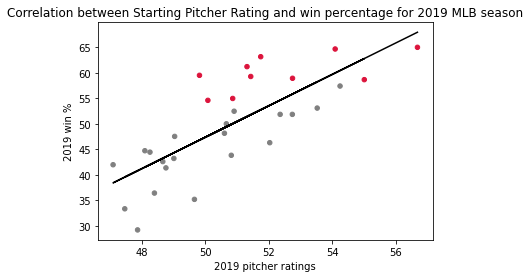

In [38]:
colors = np.where(teams_final2['Playoffs'] == 1, 'crimson', 'grey')
ax = teams_final2.plot(kind='scatter', x='2019 pitcher ratings', y='2019 win %', color=colors)
yfit = [a + b * xi for xi in teams_final2['2019 pitcher ratings']]
plt.plot(teams_final2['2019 pitcher ratings'], yfit, color='black')
plt.title('Correlation between Starting Pitcher Rating and win percentage for 2019 MLB season')

### This scatter plot with line of best fit tells a few things.

### 1.) That there is an obvious increase in average win% with average higher 
###     starting pitcher scores. 

### 2.) Only teams with an average starting pitcher rating of 49.8+ won over 50% 
###     of their games or made the playoffs. 

### 3.) That our World Series teams for 2019 (Houston and Washington), are also 
###     the teams with the highest starting pitcher ratings

In [ ]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=2)### Instantiate the sklearn class, and pick a number of clusters.

teams_final4 = pd.DataFrame([teams_final2['2019 pitcher ratings'], teams_final2['2019 win %']])
teams_final4 = teams_final4.T
kmeans.fit(teams_final4)### fit the instantiate model to our data.

labels = kmeans.labels_### the labels are the same as the 3 centers.

new_series = pd.Series(labels)### Add our new labels to the dataframe
teams_final4['clusters'] = new_series.values

Text(0.5, 1.0, 'Correlation between Starting Pitcher Rating and win percentage for 2019 MLB season')

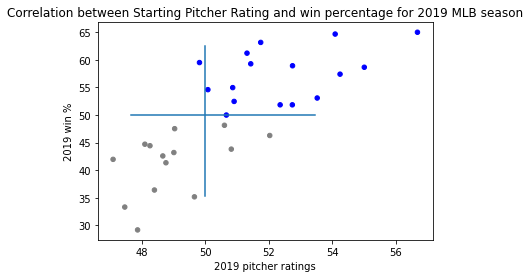

In [90]:
colors = np.where(teams_final4['clusters'] == 1, 'grey', 'blue')
ax = teams_final4.plot(kind='scatter', x='2019 pitcher ratings', y='2019 win %', color=colors)
ax.axvline(x=50, ymin=.20, ymax=.89)
ax.axhline(y=50, xmin=.10, xmax=.65)
pltt.markers.MarkerStyle(marker='+')
plt.title('Correlation between Starting Pitcher Rating and win percentage for 2019 MLB season')

In [87]:
### Begin exploration into possible correlation between starting pitcher rating
### average and playoff performance. Reduce our data to only teams that made
### the playoffs.

playoffs = teams_final2[teams_final2['Playoffs'] == 1]
playoffs = playoffs.sort_values('2019 pitcher ratings', ascending=False)
playoffs = playoffs.set_index('Team')
playoffs

,2019 pitcher ratings,2019 win %,Playoffs
Team,,,
HOU,56.683,65,1
WSN,55.0103,58.6592,1
LAD,54.0939,64.6707,1
TBD,52.7519,58.9286,1
NYY,51.7509,63.1579,1
ATL,51.4375,59.2814,1
MIN,51.3193,61.2121,1
STL,50.8696,54.9708,1
MIL,50.0885,54.6012,1


In [88]:
### This cell tells us that the average pitcher rating among playoff teams
### was over two points higher than non-playoff teams.

### The ttest strongly indicates a correlation between pitcher ratings and
### whether or not a team made the playoffs.

teams_final3 = teams_final2[teams_final2['Playoffs'] != 1]
print(np.mean(teams_final3['2019 pitcher ratings']))
print(np.mean(playoffs['2019 pitcher ratings']))

from scipy.stats import ttest_ind
ttest_ind(teams_final2['2019 pitcher ratings'], teams_final2['Playoffs'])

50.01667376203499
52.38287920122826


Ttest_indResult(statistic=113.26504811455703, pvalue=9.211662137550928e-70)

In [89]:
playoff_series = pd.DataFrame({'Series' : ['Tampa Bay vs. Oakland','Minnesota vs. New York','Tampa Bay vs. Houston','New York vs. Houston','Milwaukee vs. Washington','St. Louis vs. Atlanta','Washington vs. Los Angeles','Washington vs. St. Louis', 'Washington vs. Houston'],
                               'Does higher pitcher rank advance?' : ['Yes','Yes','Yes','Yes','Yes','No','Yes','Yes','Yes']})
playoff_series = playoff_series.set_index('Series')
playoff_series = playoff_series.style.set_table_styles([dict(selector='td', props=[('text-align', 'center')]),])
playoff_series 

,Does higher pitcher rank advance?
Series,
Tampa Bay vs. Oakland,Yes
Minnesota vs. New York,Yes
Tampa Bay vs. Houston,Yes
New York vs. Houston,Yes
Milwaukee vs. Washington,Yes
St. Louis vs. Atlanta,No
Washington vs. Los Angeles,Yes
Washington vs. St. Louis,Yes
Washington vs. Houston,Yes
